In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp

import qutip as qt
import matplotlib.pyplot as plt

from qbism import sic_povm
import jax.typing

import tomllib



import qdots_qll.all_funcs
from qdots_qll.models.models_scratch_for_drafting import *

from qdots_qll.models.game import vec, true_pars



import equinox as eqx


from jax import vmap
import jax.numpy as jnp
import jax
from jax import Array

# from jax.typing import ArrayLike
from jaxtyping import Array, Float, Complex, Int

In [2]:
names = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

In [3]:
with open("job.toml", "rb") as f:
    config = tomllib.load(f)

config

{'run': {'seed': 10,
  'pars_space_boundaries': [[0.2, 0.4],
   [0.2, 0.4],
   [0.01, 0.09],
   [-0.2, -0.5]],
  'number_of_particles': 2000,
  'max_iterations': 5000,
  'min_iterations': 100,
  'number_of_runs': 5,
  'std_stop': 1e-08},
 'logging': {'comments': 'This is a comment\n I keep writing'}}

In [4]:
from itertools import product

names_outcomes = [
    "+x",
    "-x",
    "+y",
    "-y",
    "+z",
    "-z",
]
outcomes_string_list = list(product(names_outcomes, names_outcomes))

canonical_povm_qubit = (
    jnp.array(
        [
            [0.5 * (qt.identity(2) + mat), 0.5 * (qt.identity(2) - mat)]
            for mat in [qt.sigmax(), qt.sigmay(), qt.sigmaz()]
        ]
    ).reshape(-1, 2, 2)
    / 3
)

povm_local = jnp.array(
    [
        jnp.kron(i[0], i[1])
        for i in product(canonical_povm_qubit, canonical_povm_qubit)
    ]
)

In [5]:
qubit_0_states = [qt.basis(2, 0), qt.basis(2, 1)]

max_entangled_dm_vec = vec(
    jnp.array(
        sum(
            [
                qt.tensor(q0 * q1.dag(), (q0 * q1.dag()))
                for q0 in qubit_0_states
                for q1 in qubit_0_states
            ]
        )
        .unit()
        .full()
    )
)

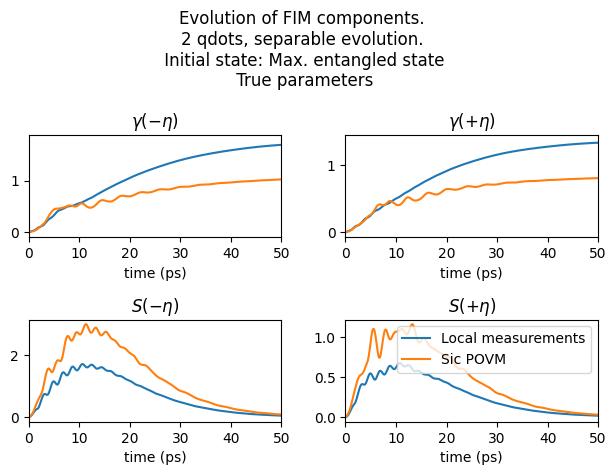

In [6]:
initial_state = max_entangled_dm_vec

times = jnp.linspace(0, 100, 1000)


model = qdots_qll.models.models_scratch_for_drafting.two_qdots_separable_maps(
    POVM_array=povm_local
)


evolution_fim_separable = jax.vmap(
    lambda t: model.fim(true_pars, t, initial_state)
)(times)


model = qdots_qll.models.models_scratch_for_drafting.two_qdots_separable_maps(
    POVM_array=jnp.array(sic_povm(4))
)

evolution_fim_sicpovm = jax.vmap(
    lambda t: model.fim(true_pars, t, initial_state)
)(times)

fig, axs = plt.subplots(2, 2)

fig.suptitle(
    "Evolution of FIM components.\n2 qdots, separable evolution.\n Initial state: Max. entangled state\n True parameters"
)

for i, ax in enumerate(axs.flat):
    ax.plot(
        times, evolution_fim_separable[:, i, i], label="Local measurements"
    )
    ax.plot(times, evolution_fim_sicpovm[:, i, i], label="Sic POVM")
    ax.set_title(names[i])
    ax.set_xlabel("time (ps)")
    ax.set_xlim(0, 50)


plt.legend()
plt.tight_layout()
plt.savefig("images/fim_components_sic_vs_local.pdf", dpi=400)

plt.show()

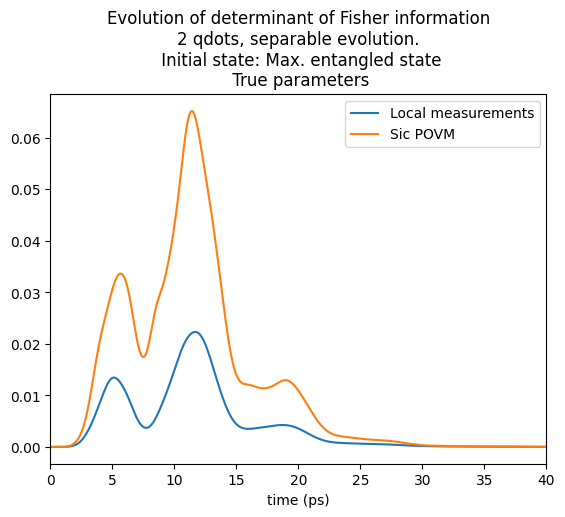

In [7]:
det_fim_separable = jax.vmap(lambda x: jnp.linalg.det(x))(
    evolution_fim_separable
)


det_fim_sicpovm = jax.vmap(lambda x: jnp.linalg.det(x))(evolution_fim_sicpovm)

plt.plot(times, det_fim_separable, label="Local measurements")
plt.plot(times, det_fim_sicpovm, label="Sic POVM")
plt.legend()
plt.title(
    "Evolution of determinant of Fisher information\n2 qdots, separable evolution.\n Initial state: Max. entangled state\n True parameters"
)
plt.xlim(0, 40)
plt.xlabel("time (ps)")
plt.savefig("images/det_fisher_sic_vs_local.pdf", dpi=400)
plt.show()

# Testing new classes

In [9]:
from qdots_qll.distributions import est_cov, est_mean

In [10]:
seed = config["run"]["seed"]

number_of_particles = config["run"]["number_of_particles"]

max_iterations = config["run"]["max_iterations"]
bnds = jnp.array(config["run"]["pars_space_boundaries"])

min_iterations = config["run"]["min_iterations"]

number_of_runs = config["run"]["number_of_runs"]

std_stop = config["run"]["std_stop"]


key = jax.random.PRNGKey(seed=seed)

key, subkey = jax.random.split(key)


# keys = jax.random.split(key, number_of_runs)


initial_cov_array = jnp.zeros(
    [
        max_iterations,
        model.number_of_parameters,
        model.number_of_parameters,
    ]
)


initial_times_array = jnp.zeros([max_iterations])

initial_particles_locations = (
    qdots_qll.all_funcs.initialize_particle_locations(
        subkey, model.number_of_parameters, number_of_particles, bnds
    )
)

initial_weights = qdots_qll.all_funcs.initialize_weights(number_of_particles)

initial_cov_array = (
    jnp.zeros(
        [
            max_iterations,
            model.number_of_parameters,
            model.number_of_parameters,
        ]
    )
    .at[0]
    .set(
        qdots_qll.distributions.est_cov(
            initial_particles_locations, initial_weights
        )
    )
)

initial_estimates_array = (
    jnp.zeros([max_iterations, model.number_of_parameters])
    .at[0]
    .set(est_mean(initial_particles_locations, initial_weights))
)

In [11]:
model = qdots_qll.models.models_scratch_for_drafting.two_qdots_separable_maps(
    POVM_array=jnp.array(sic_povm(4))
)

In [109]:
from qdots_qll.exp_design import RandomExpDesign
from qdots_qll.run import Run
from qdots_qll.smc import SMCUpdater
from qdots_qll.resamplers import LWResampler
from qdots_qll.stop_conditions import TerminationChecker

In [138]:
resampler = LWResampler()
exp_design = RandomExpDesign(0.01, 40)

smcupdater = SMCUpdater(
    model=model,
    exp_design=exp_design,
    resampler=resampler,
    initial_state=max_entangled_dm_vec,
    true_pars=true_pars,
    number_exp_repetitions=1,
)

initial_run = Run(
    iteration=0,
    key=key,
    time=0,
    weights=initial_weights,
    particles_locations=initial_particles_locations,
    cov_array=initial_cov_array,
    estimates_array=initial_estimates_array,
    times_array=initial_times_array,
    max_iterations=3000,  # max_iterations,
    min_iterations=min_iterations,
    std_threshold=std_stop,
)
stopper = TerminationChecker(10)

# Compile step once


jax.jit(smcupdater._step_force_resampling)(initial_run)

# # smcupdater._step_force_resampling(initial_run)
# f_jit = jax.jit(smcupdater._step_force_resampling)
# compilation_time = %time jax.block_until_ready(f_jit(initial_run))
# print('---')
# step_execution_time = %timeit jax.block_until_ready(f_jit(initial_run))


# print(compilation_time)
# print(step_execution_time)

Run(
  iteration=i32[],
  key=u32[2],
  time=f32[],
  weights=f32[2000],
  particles_locations=f32[2000,4],
  times_array=f32[5000],
  estimates_array=f32[5000,4],
  cov_array=f32[5000,4,4],
  max_iterations=i32[],
  min_iterations=i32[],
  std_threshold=f32[]
)

In [113]:
# jax.jit(stopper._iter_lower_than_max_iter)

<PjitFunction of <bound method TerminationChecker._iter_lower_than_max_iter of TerminationChecker(max_iterations=10)>>

In [114]:
# SMCUpdater.smc_run(jax.jit(stopper._iter_lower_than_max_iter), initial_run)

TypeError: Cannot interpret value of type <class 'jaxlib.xla_extension.PjitFunction'> as an abstract array; it does not have a dtype attribute

In [139]:
# @jit
def SMC_run(stop_checker_function, smc_step_function, initial_run):
    return jax.lax.while_loop(
        stop_checker_function, smc_step_function, initial_run
    )

In [140]:
run = SMC_run(stopper._iter_lower_than_max_iter, smcupdater.step, initial_run)

In [141]:
subkeys = jax.random.split(key, 4)

In [142]:
runs = jax.vmap(lambda key: Run(
    iteration=0,
    key=key,
    time=0,
    weights=initial_weights,
    particles_locations=initial_particles_locations,
    cov_array=initial_cov_array,
    estimates_array=initial_estimates_array,
    times_array=initial_times_array,
    max_iterations=10,  # max_iterations,
    min_iterations=min_iterations,
    std_threshold=std_stop,
))(subkeys)

In [144]:
f_runs = jax.vmap(lambda run: SMC_run(stopper._iter_lower_than_max_iter, smcupdater.step, run))(runs)

In [149]:
f_runs.cov_array.shape

(4, 5000, 4, 4)

In [158]:
runs

Run(
  iteration=i32[4],
  key=u32[4,2],
  time=i32[4],
  weights=f32[4,2000],
  particles_locations=f32[4,2000,4],
  times_array=f32[4,5000],
  estimates_array=f32[4,5000,4],
  cov_array=f32[4,5000,4,4],
  max_iterations=i32[4],
  min_iterations=i32[4],
  std_threshold=f32[4]
)

[]

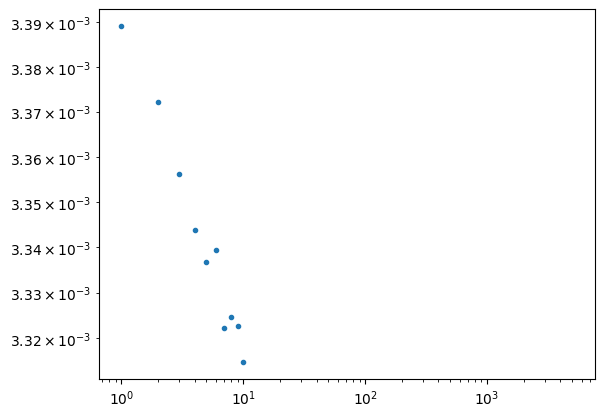

In [156]:
plt.plot(f_runs.cov_array[3, :, 0, 0], '.')
plt.loglog()

In [128]:
?jax.pmap

Signature:
jax.pmap(
    fun: 'Callable',
    axis_name: 'AxisName | None' = None,
    *,
    in_axes=0,
    out_axes=0,
    static_broadcasted_argnums: 'int | Iterable[int]' = (),
    devices: 'Sequence[xc.Device] | None' = None,
    backend: 'str | None' = None,
    axis_size: 'int | None' = None,
    donate_argnums: 'int | Iterable[int]' = (),
    global_arg_shapes: 'tuple[tuple[int, ...], ...] | None' = None,
) -> 'Any'
Docstring:
Parallel map with support for collective operations.

The purpose of :py:func:`pmap` is to express single-program multiple-data
(SPMD) programs. Applying :py:func:`pmap` to a function will compile the
function with XLA (similarly to :py:func:`jit`), then execute it in parallel
on XLA devices, such as multiple GPUs or multiple TPU cores. Semantically it
is comparable to :py:func:`vmap` because both transformations map a function
over array axes, but where :py:func:`vmap` vectorizes functions by pushing the
mapped axis down into primitive operations, :py:fu

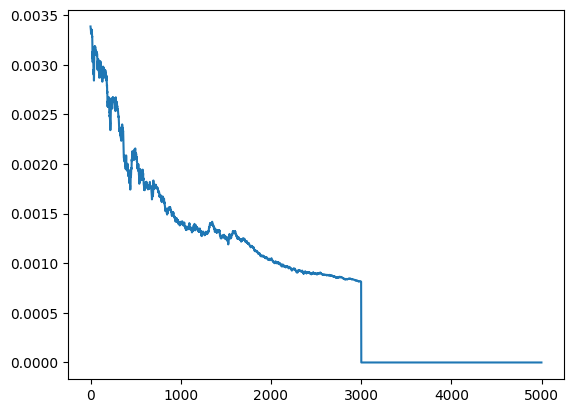

In [127]:
plt.plot(run.cov_array[:, 0, 0])
# plt.loglog()

In [103]:
%timeit jax.block_until_ready(smcupdater._step_force_resampling( initial_run))

4.17 ms ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
# Without precompilation
%timeit jax.block_until_ready(SMC_run(stopper._iter_lower_than_max_iter, smcupdater.step, initial_run))

1.41 s ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
#Already precompiled
%timeit jax.block_until_ready(SMC_run(stopper._iter_lower_than_max_iter, smcupdater.step, initial_run))

TypeError: Cannot interpret value of type <class 'method'> as an abstract array; it does not have a dtype attribute

In [97]:
from timeit import timeit

timeit(
    jax.block_until_ready(
        SMC_run(
            stopper._iter_lower_than_max_iter, smcupdater.step, initial_run
        )
    )
)

ValueError: stmt is neither a string nor callable

In [90]:
initial_run.max_iterations

5000

In [71]:
stopper._iter_lower_than_max_iter(initial_run)

Array(True, dtype=bool)

In [42]:
uy = jax.lax.while_loop(
    stopper._iter_lower_than_max_iter, smcupdater.step, initial_run
)

In [62]:
# compilation time 
%timeit smcupdater.step(initial_run)

3.73 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
initial_run.return_mutable_attributes().keys()

dict_keys(['iteration', 'key', 'weights', 'particles_locations', 'cov_array', 'estimates_array', 'times_array'])

In [50]:
init = initial_run.return_mutable_attributes()

In [69]:
%timeit smcupdater.step.lower(smcupdater, initial_run).compile()


681 µs ± 52.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [66]:
f = jax.jit(lambda x: x * 2)
%timeit f.lower(1).compile()

187 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


True
True
True
True
True
True
True
True
True
False
False
False


[]

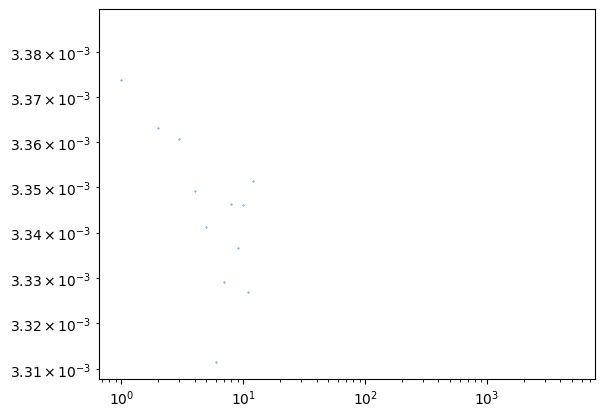

In [40]:
run = initial_run

for _ in range(12):

    run = smcupdater.step(run)
    print(stopper._iter_lower_than_max_iter(run))

plt.plot(run.cov_array[:, 0, 0], ".", ms=0.7)
plt.loglog()

In [ ]:
# smcupdater._iteration_smc(**initial_run.return_mutable_attributes())
aux = smcupdater.step(initial_run)


run = initial_run

for _ in range(2000):

    run = smcupdater.step(run)

plt.plot(run.cov_array[:, 0, 0], ".", ms=0.7)
plt.loglog()

In [373]:
# class random_experimental_design(eqx.Module):
#     t_min: float
#     t_max: float

#     def __init__(self, t_min, t_max) -> None:
#         self.t_min = t_min
#         self.t_max = t_max

#     @jit
#     def generate_time(self, key, *args, **kwargs):
#         return jax.random.uniform(
#             key=key, minval=self.t_min, maxval=self.t_max
#         )


# st_obj = random_experimental_design(0.01, 40)
# print(st_obj)

# st_obj.generate_time(key=subkey)

random_experimental_design(t_min=0.01, t_max=40)


Array(31.503296, dtype=float32)

(Array(1, dtype=int32, weak_type=True),
 Array([1010921706, 2210032700], dtype=uint32),
 Array(6.7036304, dtype=float32),
 Array([0.00054031, 0.00050287, 0.00049441, ..., 0.00045976, 0.00047102,
        0.00049325], dtype=float32),
 Array([[ 0.26509878,  0.29076996,  0.06442443, -0.44206446],
        [ 0.35486212,  0.2519247 ,  0.06125064, -0.32375377],
        [ 0.28812855,  0.39841348,  0.04470122, -0.37076157],
        ...,
        [ 0.39157322,  0.33658767,  0.02338689, -0.30054462],
        [ 0.24929021,  0.36732906,  0.08645543, -0.20491257],
        [ 0.29567227,  0.3600805 ,  0.05813336, -0.3217228 ]],      dtype=float32),
 Array([[3.3918917e-03, 2.9996037e-05, 4.0877610e-05, 5.5909157e-05],
        [2.9996037e-05, 3.4090430e-03, 3.3561140e-05, 4.9322844e-06],
        [4.0878542e-05, 3.3561140e-05, 5.3814822e-04, 6.9435686e-05],
        [5.5909157e-05, 4.9397349e-06, 6.9435686e-05, 7.2340369e-03]],      dtype=float32),
 Array([ 0.29881588,  0.29837316,  0.05071411, -0.3551361 ]

In [362]:
# from qdots_qll.distributions import ESS
# from qdots_qll.distributions import est_mean, est_cov
# from qdots_qll.run import Run


# @jit
# def update_array_at(index, arr, new_element):
#     new_arr = arr.at[index].set(new_element)
#     return new_arr


# class SMCUpdater(eqx.Module):
#     model: eqx.Module
#     exp_design: eqx.Module
#     resampler: eqx.Module
#     initial_state: jax.Array
#     true_pars: jax.Array
#     number_exp_rep_matrix_shape: jax.Array

#     def __init__(
#         self,
#         model,
#         exp_design,
#         resampler,
#         initial_state,
#         true_pars,
#         number_exp_repetitions,
#     ):
#         self.model = model
#         self.exp_design = exp_design
#         self.resampler = resampler
#         self.initial_state = initial_state
#         self.true_pars = true_pars
#         self.number_exp_rep_matrix_shape = jnp.identity(number_exp_repetitions)

#     def likelihood_data(self, lkl_results, result):
#         return lkl_results[result]

#     def update_weights(self, lkl, weights):
#         new_weights = lkl * weights
#         new_weights = new_weights / jnp.sum(new_weights)
#         return new_weights

#     # @jit
#     def _iteration_smc_new_weights(
#         self, key, iteration, particles_locations, weights, **kwargs
#     ):
#         key, subkey = jax.random.split(key)

#         t = self.exp_design.generate_time(
#             key=subkey,
#             particles_locations=particles_locations,
#             weights=weights,
#         )
#         number_of_exp_re = self.number_exp_rep_matrix_shape.shape[0]
#         keys = jax.random.split(key, number_of_exp_re + 1)

#         key = keys[0]

#         results = jax.vmap(
#             self.model.generate_data, in_axes=(0, None, None, None)
#         )(keys[1:], self.true_pars, t, self.initial_state)

#         all_lkls = jax.vmap(
#             self.model.likelihood_particle, in_axes=(0, None, None)
#         )(particles_locations, t, self.initial_state)

#         lkl_results_all_particles = vmap(
#             self.likelihood_data, in_axes=(0, None)
#         )(all_lkls, results)

#         lkl = jnp.prod(lkl_results_all_particles, axis=1)

#         new_weights = self.update_weights(lkl, weights)
#         # return key, iteration + 1, particles_locations, new_weights

#         return {
#             "iteration": iteration + 1,
#             "key": key,
#             "weights": new_weights,
#             "particles_locations": particles_locations,
#             "time": t,
#             # self.cov_array,
#         }

#     @jit
#     def step(self, run_obj):

#         updated_variables_bf_resampling = self._iteration_smc_new_weights(
#             **run_obj.return_mutable_attributes()
#         )

#         updated_variables = jax.lax.cond(
#             ESS(updated_variables_bf_resampling["weights"])
#             > updated_variables_bf_resampling["weights"].shape[0] / 2,
#             lambda a: a,
#             lambda a: {**a, **self.resampler.resample(**a)},
#             updated_variables_bf_resampling,
#         )

#         index_iter = updated_variables["iteration"]
#         new_cov_array = update_array_at(
#             index_iter, run_obj.cov_array, est_cov(**updated_variables)
#         )
#         new_estimates_array = update_array_at(
#             index_iter, run_obj.estimates_array, est_mean(**updated_variables)
#         )
#         new_times_array = update_array_at(
#             index_iter, run_obj.times_array, updated_variables["time"]
#         )

#         return Run(
#             **{
#                 **updated_variables,
#                 **run_obj.return_immutable_attributes(),
#                 **{
#                     "cov_array": new_cov_array,
#                     "estimates_array": new_estimates_array,
#                     "times_array": new_times_array,
#                 },
#             }
#         )

In [363]:
# from qdots_qll.distributions import est_mean, est_cov


# class LWResampler(eqx.Module):
#     a: int

#     def __init__(self, a=0.98):
#         self.a = a

#     def resample(self, key, particles_locations, weights, **kwargs):
#         no_particles = particles_locations.shape[0]
#         no_pars = particles_locations.shape[1]
#         mu = est_mean(particles_locations, weights)
#         h = jnp.sqrt(1 - self.a**2)
#         sigma = est_cov(particles_locations, weights) * h**2

#         # sigma = (
#         #     jnp.diag(jnp.array([10, 10, 1, 1, 1]))
#         #     @ sigma
#         #     @ jnp.diag(jnp.array([10, 10, 1, 1, 1]))
#         # )

#         key, subkey = jax.random.split(key)
#         new_mu = (
#             self.a
#             * jax.random.choice(
#                 subkey, particles_locations, shape=(no_particles,), p=weights
#             )
#             + (1 - self.a) * mu
#         )

#         key, subkey = jax.random.split(key)
#         new_particles_location = jax.random.multivariate_normal(
#             subkey, new_mu, sigma, shape=(no_particles,)
#         )

#         new_weights = jnp.ones(no_particles) / no_particles
#         # return key, new_particles_location, new_weights
#         return {
#             "key": key,
#             "weights": new_weights,
#             "particles_locations": new_particles_location,
#             # self.cov_array,
#         }

SMCUpdater(
  model=two_qdots_separable_maps(
    d=4,
    matrix_d=f32[4,4],
    positive_eps=1e-08,
    number_of_parameters=4,
    delta=0.12739334807998307,
    Omega=0.5,
    one_dot_system_hamiltonian=f32[2,2],
    A=i32[2,2],
    POVM_arr=c64[16,4,4],
    basis_elements=f32[4,4]
  ),
  exp_design=random_experimental_design(t_min=0.01, t_max=40),
  resampler=LWResampler(a=0.98),
  initial_state=c64[16],
  true_pars=f32[4],
  number_exp_rep_matrix_shape=f32[1,1]
)

In [403]:
@jit
def aux(run):
    for _ in range(100):

        run = smcupdater.step(run)
    return run


aux(initial_run)

2024-03-14 10:51:35.045386: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_aux] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


[]

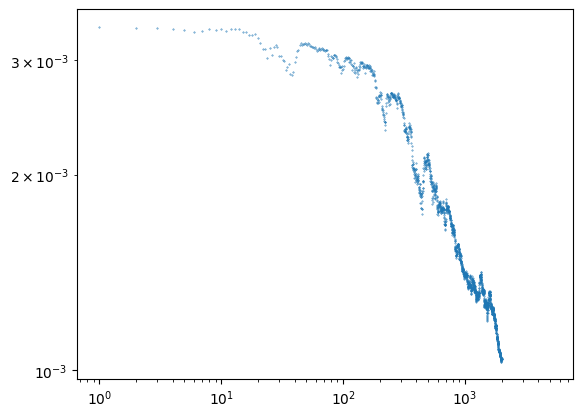

In [376]:
run

Run(
  iteration=i32[],
  key=u32[2],
  time=f32[],
  weights=f32[2000],
  particles_locations=f32[2000,4],
  times_array=f32[5000],
  estimates_array=f32[5000,4],
  cov_array=f32[5000,4,4],
  max_iterations=i32[],
  min_iterations=i32[],
  std_threshold=f32[]
)

In [ ]:
# Testing some while things

# def while_loop(cond_fun, body_fun, init_val):
#   val = init_val
#   while cond_fun(val):
#     val = body_fun(val)
#   return val

In [ ]:
# the initial value must be the initial run
# A run object nees to be generated

# Testing distribution and benchmark

In [140]:
from qdots_qll.distributions import Distribution, Distribution2

d = Distribution(2000, 4)

In [141]:
d.est_mean(initial_particles_locations, initial_weights)

Array([ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ], dtype=float32)

In [142]:
d.est_covariance(initial_particles_locations, initial_weights)

Array([[ 3.3859462e-03,  2.7514994e-05,  4.4315122e-05,  4.9903989e-05],
       [ 2.7514994e-05,  3.3969879e-03,  3.3707358e-05, -2.5980175e-05],
       [ 4.4315122e-05,  3.3707358e-05,  5.3848559e-04,  5.7097524e-05],
       [ 4.9903989e-05, -2.5980175e-05,  5.7097524e-05,  7.3120669e-03]],      dtype=float32)

In [143]:
d2.est_mean()

Array([ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ], dtype=float32)

In [156]:
jax.vmap(f2_test, in_axes=(0, None))(
    jnp.array([initial_particles_locations] * 1000), initial_weights
)

Array([[ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       ...,
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ]],      dtype=float32)

In [157]:
jax.vmap(f1_test, in_axes=(None, 0, None))(
    d, jnp.array([initial_particles_locations] * 1000), initial_weights
)

Array([[ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       ...,
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ]],      dtype=float32)

In [165]:
%time jax.vmap((f1_test), in_axes=(None, 0, None))(d, jnp.array([initial_particles_locations]*1000), initial_weights).block_until_ready()


CPU times: user 174 ms, sys: 25.6 ms, total: 200 ms
Wall time: 172 ms


Array([[ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       ...,
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ]],      dtype=float32)

In [166]:
%timeit jax.vmap((f1_test), in_axes=(None, 0, None))(d, jnp.array([initial_particles_locations]*1000), initial_weights).block_until_ready()

137 ms ± 9.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [167]:
%time jax.vmap(f2_test, in_axes=(0, None))(jnp.array([initial_particles_locations]*1000), initial_weights).block_until_ready()

CPU times: user 192 ms, sys: 17.7 ms, total: 210 ms
Wall time: 175 ms


Array([[ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       ...,
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ],
       [ 0.2994399 ,  0.2993235 ,  0.05016581, -0.3506033 ]],      dtype=float32)

In [168]:
%timeit jax.vmap(f2_test, in_axes=(0, None))(jnp.array([initial_particles_locations]*1000), initial_weights).block_until_ready()

135 ms ± 5.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [164]:
@jit
def f1_test(d, initial_particles_locations, initial_weights):
    return d.est_mean(initial_particles_locations, initial_weights)


@jit
def f2_test(initial_particles_locations, initial_weights):
    return Distribution2(
        initial_particles_locations, initial_weights
    ).est_mean()